<a href="https://colab.research.google.com/github/Eric-rWang/VivoX/blob/main/PPG_VivoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import h5py

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

os.chdir("/content/PPG ML")
print(os.getcwd())

/content/PPG ML


VivoX transformer model:
<ul>
<li>Linear projection from flattened window inputs to d_model</li>
<li>Sinusoidal positional encodings</li>
<li>Standard encoder stack</li>
<li>Mean pooling and MLP head for arterial and venous regression</li>
</ul>

In [5]:
class PositionalEncoding(nn.Module):
    """
    Implements sinusoidal positional encoding.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: (batch_size, seq_len, d_model) with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


class vivoxTransformer(nn.Module):
    """
    Simple Transformer model for arterial & venous SpO2 prediction from multichannel PPG.

    Args:
        num_channels: number of input channels (e.g., 36)
        window_size: number of time samples per window (e.g., 350)
        d_model: embedding dimension
        nhead: number of attention heads
        num_layers: number of Transformer encoder layers
        dim_feedforward: dimension of the MLP in encoder layers
        dropout: dropout rate
    """
    def __init__(
        self,
        num_channels: int = 36,
        window_size: int = 350,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 512,
        dropout: float = 0.1, # Increased from 0.1
        max_windows: int = 200,
    ):
        super().__init__()
        input_dim = num_channels * window_size

        # 1) Linear projection of each window to d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        # self.input_norm = nn.LayerNorm(d_model) # Normalize

        # 2) Positional encoding for up to max_windows
        self.pos_enc = PositionalEncoding(d_model, max_len=max_windows)

        # 3) Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # allows (batch, seq, feature)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # 4) Regression head for arterial & venous SpO2
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (batch_size, num_windows, num_channels, window_size)
        Returns:
            Tensor of shape (batch_size, 2) containing [SpO2_art, SpO2_ven]
        """
        batch, num_windows, C, W = x.size()
        # Flatten channels & time
        x = x.view(batch, num_windows, C * W)             # (batch, num_windows, input_dim)

        # Embed
        x = self.input_proj(x)                           # (batch, num_windows, d_model)

        # Normalize
        # x = self.input_norm(x)

        # Add positional encoding
        x = self.pos_enc(x)                              # (batch, num_windows, d_model)

        # Transformer encoding
        x = self.transformer(x)                          # (batch, num_windows, d_model)

        # Pool across time windows
        rep = x.mean(dim=1)                              # (batch, d_model)

        # Predict SpO2
        out = self.head(rep)                             # (batch, 2)

        return out

Loading in data set from phantom setup.

In [6]:
def import_h5py(file_path):
  with h5py.File(file_path, 'r') as f:
      X = f['waveforms'][:]
      y = f['labels'][:]

      return X, y

file_path = "Shifting_Position_2.h5"
combined_data, labels_array = import_h5py(file_path)

Splitting imported dataset into training and testing sets.

In [7]:
labels_df = pd.DataFrame(
        labels_array,
        columns=['arterial_saturation', 'venous_saturation']
)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    combined_data, labels_array, test_size=0.2, random_state=42
)

# Print out shape of train and test data
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (2126, 350, 36)
X_test  shape: (532, 350, 36)


Training CNN function. Setting epoch to 500 for now. Since channels of data have their own unique position, we add positional as well as wavelength embedding.

In [8]:
save_path = 'vivoxTransformer_2.pth'

# --- Hyperparameters & settings ---
num_channels = 36
window_size  = 350
d_model      = 128
batch_size   = 16
lr           = 1e-4
weight_decay = 5e-5
num_epochs   = 250

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# 1) Convert NumPy to torch tensors (no permute needed; model expects (B, T, C))
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# 2) permute & unsqueeze so each sample is (1 window, 36 channels, 350 timesteps)
#    result: (N, 1, 36, 350)
X_train_rs = X_train_t.permute(0, 2, 1).unsqueeze(1)
X_test_rs  = X_test_t .permute(0, 2, 1).unsqueeze(1)
# assuming X_train_rs is (N,1,36,350)
mean = X_train_rs.mean(dim=(0,1,3), keepdim=True)  # per-channel mean
std  =  X_train_rs.std(dim=(0,1,3), keepdim=True)  # per-channel std
X_train_rs = (X_train_rs - mean) / (std + 1e-6)
X_test_rs  = (X_test_rs  - mean) / (std + 1e-6)

# 3) DataLoaders
train_loader = DataLoader(TensorDataset(X_train_rs, y_train_t),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_rs,  y_test_t),
                          batch_size=batch_size)

In [10]:
# 2) Model Setup
model = vivoxTransformer(
            num_channels=num_channels,
            window_size=window_size,
            d_model=d_model
        ).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [11]:
best_train_loss = float('inf')
print('Starting Training Loop')

# 4) Training loop with device‐moves
for epoch in range(1, num_epochs + 1):
    # -- Train --
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)    # Xb is (batch, 1, 36, 350)
        preds  = model(Xb)                      # no more unpacking error
        loss   = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # -- Evaluate --
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            test_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    test_loss /= len(test_loader.dataset)

    # -- Checkpoint --
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), save_path)
        status = '→ saved best'
    else:
        status = ''
    print(f"Epoch {epoch:3d}: Train {train_loss:.4f}, Test {test_loss:.4f} {status}")

print("Training complete. Best test loss:", best_train_loss)

Starting Training Loop
Epoch   1: Train 3129.4812, Test 2886.0058 → saved best
Epoch   2: Train 2614.4900, Test 2278.0887 → saved best
Epoch   3: Train 1949.1603, Test 1578.0049 → saved best
Epoch   4: Train 1278.7579, Test 959.3598 → saved best
Epoch   5: Train 740.7799, Test 519.2253 → saved best
Epoch   6: Train 385.6335, Test 253.9777 → saved best
Epoch   7: Train 188.7915, Test 127.7717 → saved best
Epoch   8: Train 105.7453, Test 85.6460 → saved best
Epoch   9: Train 81.1354, Test 76.5727 → saved best
Epoch  10: Train 75.8926, Test 75.3071 → saved best
Epoch  11: Train 74.6769, Test 71.8521 → saved best
Epoch  12: Train 63.4073, Test 49.6339 → saved best
Epoch  13: Train 35.2264, Test 24.0171 → saved best
Epoch  14: Train 20.3195, Test 15.8442 → saved best
Epoch  15: Train 17.4971, Test 15.6791 → saved best
Epoch  16: Train 16.7551, Test 14.8292 → saved best
Epoch  17: Train 16.0750, Test 14.2729 → saved best
Epoch  18: Train 15.4051, Test 13.6447 → saved best
Epoch  19: Train 14

Visualizing the channel embeddings

In [12]:
W = model.input_proj.weight.data.cpu().numpy()

num_channels = 36
window_size  = 350
d_model       = W.shape[0]

channel_embs = np.zeros((num_channels, d_model))
for c in range(num_channels):
    start = c*window_size
    end   = (c+1)*window_size
    block = W[:, start:end]           # shape (d_model, window_size)
    channel_embs[c] = block.mean(1)   # now (d_model,)

Computer pairwise similarities

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(channel_embs)  # shape (36,36)

Visualization

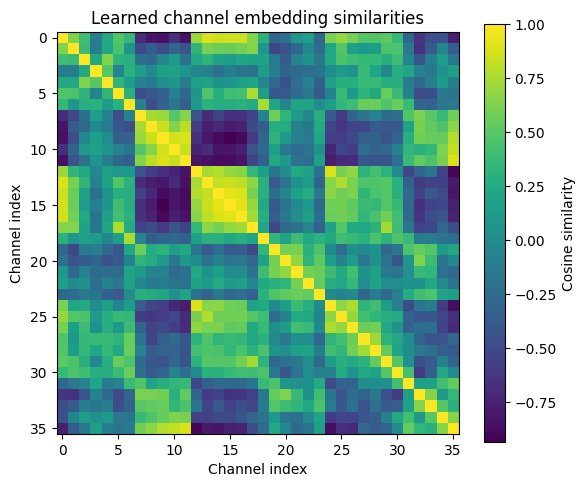

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(sim_matrix, aspect='equal')
plt.colorbar(label='Cosine similarity')
plt.xlabel('Channel index')
plt.ylabel('Channel index')
plt.title('Learned channel embedding similarities')
plt.tight_layout()
plt.show()